# Stocks Backtrading Strategy (Shorting)

In [99]:
#import statements
from typing import Tuple, Union, List, Any

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from numpy import ndarray
from pandas import DataFrame, Series

from utils.OHLC_Helper import getAlphaOHLC

sns.set_theme(color_codes=True)
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import yfinance as yf
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries
import talib
sns.set_theme(color_codes=True)
API_KEY = 'EC1W3AWVDZ3LA1T8'
ts= TimeSeries(key=API_KEY,output_format='pandas' )
ti = TechIndicators(key=API_KEY,output_format='pandas')
sns.set(rc={'figure.figsize':(30,9)})

In [100]:
ticker = 'AMZN'
interval = '1min'
df_unstructed, meta_data =ts.get_intraday(symbol=ticker, interval=interval, outputsize='full', )
# appleData,meta_data =ts.get_daily(symbol='AAPL',outputsize='full')
df = getAlphaOHLC(df_unstructed, )
df

,open,high,low,close,volume
date,,,,,
2022-04-20 04:01:00,3136.00,3136.00,3136.00,3136.00,282.0
2022-04-20 04:25:00,3137.25,3137.25,3137.25,3137.25,183.0
2022-04-20 05:45:00,3143.00,3143.00,3143.00,3143.00,445.0
2022-04-20 05:53:00,3140.00,3140.00,3140.00,3140.00,500.0
2022-04-20 05:54:00,3142.00,3142.00,3142.00,3142.00,540.0
...,...,...,...,...,...
2022-05-04 18:45:00,2511.00,2511.00,2511.00,2511.00,1070.0
2022-05-04 18:55:00,2511.00,2511.00,2511.00,2511.00,286.0
2022-05-04 19:48:00,2510.00,2510.00,2510.00,2510.00,172.0


In [101]:
period = 40
df['EMA_15']= df['close'].ewm(span=period,min_periods=period).mean()
df['rolling_std'] = df['close'].rolling(window=period).std().shift(1)
df['upper'] = df['EMA_15'] + 1.6*df['rolling_std']
df['lower'] = df['EMA_15'] - 1.6*df['rolling_std']

/var/folders/c9/8r4kyvcj2n549rc9ckxkqqzh0000gn/T/ipykernel_12702/2869053063.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['isShort'][date]= 1
/var/folders/c9/8r4kyvcj2n549rc9ckxkqqzh0000gn/T/ipykernel_12702/2869053063.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['isClose'][date]= 1


thnh


DatetimeIndex(['2022-04-20 11:12:00', '2022-04-20 13:56:00',
               '2022-04-20 15:52:00', '2022-04-21 09:59:00',
               '2022-04-22 09:30:00', '2022-04-22 10:21:00',
               '2022-04-22 16:00:00', '2022-04-25 13:02:00',
               '2022-04-25 15:04:00', '2022-04-26 08:01:00',
               '2022-04-26 15:06:00', '2022-04-27 09:31:00',
               '2022-04-27 09:58:00', '2022-04-27 11:54:00',
               '2022-04-27 13:01:00', '2022-04-27 19:32:00',
               '2022-04-28 08:53:00', '2022-04-28 11:38:00',
               '2022-04-28 15:36:00', '2022-04-28 16:03:00',
               '2022-04-29 07:15:00', '2022-04-29 12:01:00',
               '2022-04-29 17:58:00', '2022-05-02 07:14:00',
               '2022-05-02 09:34:00', '2022-05-02 14:58:00',
               '2022-05-02 18:45:00', '2022-05-03 06:49:00',
               '2022-05-03 10:48:00', '2022-05-03 11:39:00',
               '2022-05-03 14:02:00', '2022-05-03 15:43:00',
               '2022-05-

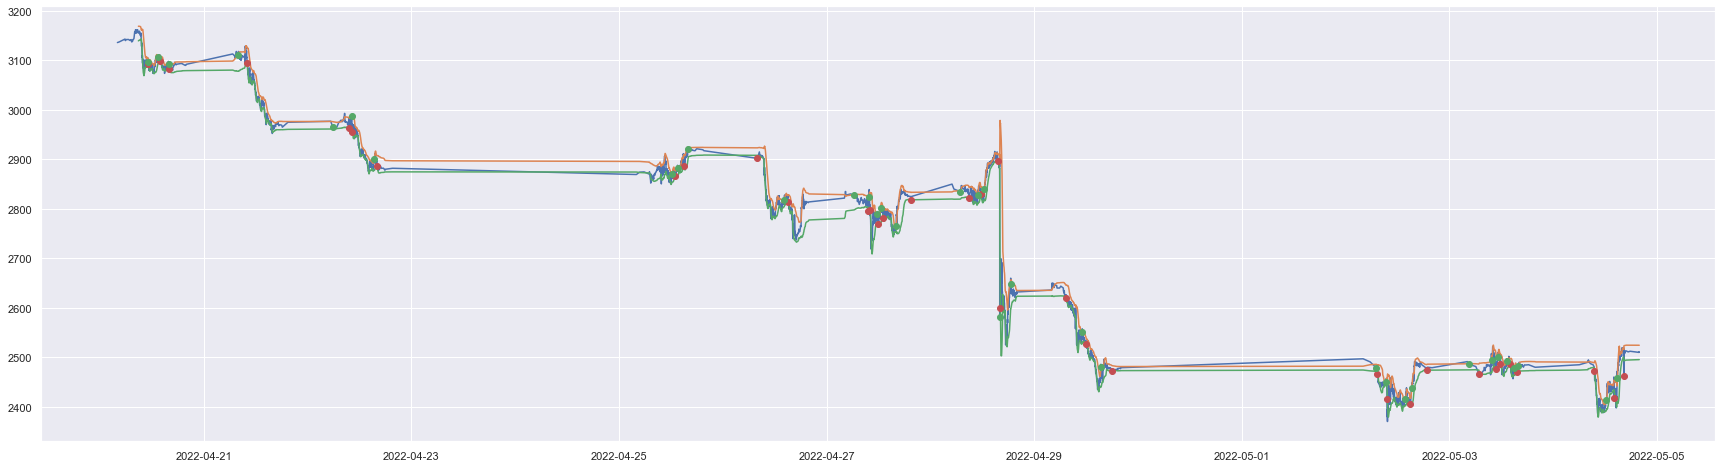

In [102]:
# iterate through df data and create signals
# df = df[-700:]
last_close = 1000
last_buy_date=None
close_dates = []
short_dates = []
df['isShort'] = 0
df['isClose'] = 0
for date,row in df.iterrows():
    close = row['close']
    upper = row['upper']
    lower = row['lower']
    if(close<upper and last_close>upper and not last_buy_date ):
        # sell
        # print(f"sell on {date}")
        short_dates.append(date)
        df['isShort'][date]= 1
        last_buy_date = date
    elif(close<lower and last_buy_date ):
        # buy
        # print(f"buy on {date}")
        close_dates.append(date)
        df['isClose'][date]= 1
        last_buy_date = None
    else:
        pass
    last_close = close
    # print(f' date {date}  close {row["close"]}')
buys = df[df['isShort']==1]
sells = df[df['isClose']==1]

# print(buy_dates)
# print(sell_dates)

fig, ax = plt.subplots(figsize=(30,8))
# plt.figure(figsize=(42,8))
plt.plot(df['close'])
plt.plot(df['upper'])
plt.plot(df['lower'])
plt.plot(sells.index,sells['close'],'ro')
plt.plot(buys.index,buys['close'],'go')
print('thnh')


sells.index


lim [(Timestamp('2022-04-20 11:01:00'), Timestamp('2022-04-20 11:12:00')), (Timestamp('2022-04-20 13:18:00'), Timestamp('2022-04-20 13:56:00')), (Timestamp('2022-04-20 15:50:00'), Timestamp('2022-04-20 15:52:00')), (Timestamp('2022-04-21 07:51:00'), Timestamp('2022-04-21 09:59:00')), (Timestamp('2022-04-22 05:46:00'), Timestamp('2022-04-22 09:30:00')), (Timestamp('2022-04-22 10:11:00'), Timestamp('2022-04-22 10:21:00')), (Timestamp('2022-04-22 15:20:00'), Timestamp('2022-04-22 16:00:00')), (Timestamp('2022-04-25 12:17:00'), Timestamp('2022-04-25 13:02:00')), (Timestamp('2022-04-25 13:33:00'), Timestamp('2022-04-25 15:04:00')), (Timestamp('2022-04-25 16:00:00'), Timestamp('2022-04-26 08:01:00')), (Timestamp('2022-04-26 14:13:00'), Timestamp('2022-04-26 15:06:00')), (Timestamp('2022-04-27 06:21:00'), Timestamp('2022-04-27 09:31:00')), (Timestamp('2022-04-27 09:46:00'), Timestamp('2022-04-27 09:58:00')), (Timestamp('2022-04-27 11:36:00'), Timestamp('2022-04-27 11:54:00')), (Timestamp('202

[5.210000000000036,
 8.654199999999946,
 10.514999999999873,
 14.550000000000182,
 2.669999999999618,
 31.639999999999873,
 13.949999999999818,
 4.7800000000002,
 -3.2669999999998254,
 18.139999999999873,
 3.6100000000001273,
 31.96499999999969,
 25.960000000000036,
 19.5,
 21.866599999999835,
 -51.940000000000055,
 13.340000000000146,
 -1.3699999999998909,
 -56.00009999999975,
 -18.79989999999998,
 28.700000000000273,
 23.585000000000036,
 8.283199999999852,
 11.7199999999998,
 34.440000000000055,
 10.75500000000011,
 -37.289999999999964,
 19.0,
 19.29000000000042,
 13.379999999999654,
 6.880000000000109,
 7.700000000000273,
 10.66000000000031,
 -3.1550000000002,
 -3.8700000000003456]

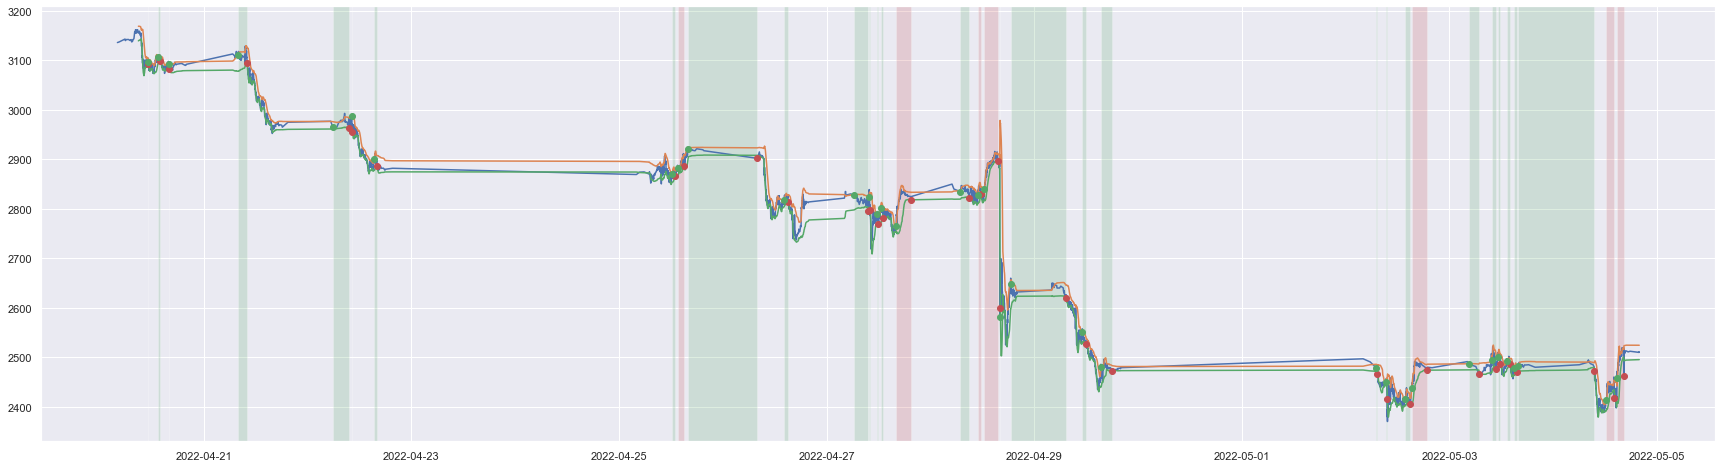

In [103]:
def shortCloseChart(ohlc_df, short_signal, close_signal, columns):
    transactions = pd.concat([short_signal, close_signal], axis=0)
    transactions.sort_index(inplace=True)
    fig, ax = plt.subplots(figsize=(30, 8))
    # plt.figure(figsize=(42,8))
    plt.plot(ohlc_df['close'])
    plt.plot(ohlc_df['upper'])
    plt.plot(ohlc_df['lower'])
    plt.plot(close_signal.index, close_signal['close'], 'ro')
    plt.plot(short_signal.index, short_signal['close'], 'go')

    last_short_date = None
    last_short_price = None
    profits = []
    lim = []

    for date, row in transactions.iterrows():
        if (row['isClose'] == 1 and last_short_price is not None ):
            profit =  last_short_price - row['close']
            ax.axvspan(last_short_date, date, facecolor='g' if profit > 0 else 'r', alpha=0.2)
            profits.append(profit)
            lim.append((last_short_date,date))
        else:
            last_short_date = date
            last_short_price = row['close']
    # print(f'profits {profits}')
    print(f'lim {lim}')
    return (transactions,profits)
transactions,profits = shortCloseChart(df, buys, sells, ['close'])
profits

In [105]:
print(f'number of transactions {len(transactions)}\n')

total_profit = sum(profits)
print(f'total profit {total_profit}')

short_and_hold_profit = df['close'][-1] - df['close'][0]
print(f'short and hold profit {short_and_hold_profit}\n')

print(f'profit % {round((total_profit/buys["close"][0])*100,1)}')


number of transactions 70

total profit 245.05200000000013
short and hold profit -626.0

profit % 7.9
